# Titanic
Achieving 86% accuracy on a test data set using an xgboost classifier to predict whether a passenger survived the Titanic disaster

In [1]:
import pandas as pd
import numpy as np
from math import ceil

%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
kaggle = pd.read_csv('test.csv')

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature Engineering
### Creating has_cabin

In [3]:
# does the first letter in cabin correlate to floor of ship?
grp = df.groupby(df['Cabin'].fillna('Z').apply(lambda x: x[0]))

# It looks like passengers without a cabin were significantly less likely to survive
grp.Survived.sum() / grp.Survived.count()

Cabin
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
Z    0.299854
Name: Survived, dtype: float64

In [4]:
# creating a column in our dataframe that holds whether or not Cabin is NaN
def create_has_cabin(cabin):
    if pd.notnull(cabin):
        return 1
    return 0

df['has_cabin'] = df['Cabin'].apply(create_has_cabin)
kaggle['has_cabin'] = kaggle['Cabin'].apply(create_has_cabin)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


### Binarizing Sex

In [5]:
df.Sex.unique()

array(['male', 'female'], dtype=object)

In [6]:
map_sex = {'male':1, 'female':0}

df['is_male'] = df['Sex'].map(map_sex)
df.drop('Sex', axis=1, inplace=True)
kaggle['is_male'] = kaggle['Sex'].map(map_sex)
kaggle.drop('Sex', axis=1, inplace=True)

df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_cabin,is_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,0,1


### Creating has_age

In [7]:
# creating a column in our dataframe that holds whether or not Age is NaN
def create_has_age(age):
    if pd.notnull(age):
        return 1
    return 0

df['has_age'] = df['Age'].apply(create_has_age)
kaggle['has_age'] = kaggle['Age'].apply(create_has_age)

df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_cabin,is_male,has_age
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,1,0,1
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,1,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,0,1,1


In [8]:
grp = df.groupby(df['has_age'])

# passengers who have an age are more likely to have survived
grp.Survived.sum() / grp.Survived.count()

has_age
0    0.293785
1    0.406162
Name: Survived, dtype: float64

### Dealing with null Ages

In [ ]:
def create_age_bin(age):
    bin_size = 5
    null_age_default = 42
    if np.isnan(age):
        return null_age_default
    return ceil(age/bin_size)*bin_size

df['age_bin'] = df['Age'].apply(create_age_bin)
kaggle['age_bin'] = kaggle['Age'].apply(create_age_bin)

df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_cabin,is_male,has_age,age_bin
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,1,25
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,1,0,1,40
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,30
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,1,0,1,35
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,0,1,1,35


In [ ]:
my_list = [25, 40, 30, 35, 42, 55,  5, 15, 60, 20, 10, 70, 45, 50, 65, 75, 80]
my_list.sort()

print(my_list)

[5, 10, 15, 20, 25, 30, 35, 40, 42, 45, 50, 55, 60, 65, 70, 75, 80]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11d1af240>,
      dtype=object)

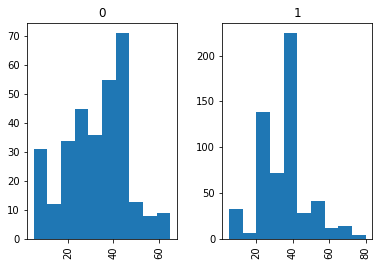

In [ ]:
df.hist(column='age_bin', by='is_male')

In [ ]:
def get_survival_probability(group_df):
    bin_survivors = len(group_df[group_df['Survived'] == 1])
    bin_passengers = len(group_df)
    return bin_survivors/bin_passengers

series = df.groupby(['is_male', 'age_bin']).apply(get_survival_probability)
series.plot(kind='bar')

### Creating is_child

In [ ]:
def create_is_child(age):
    if np.isnan(age):
        return 0
    if age <= 20:
        return 1
    return 0

df['is_child'] = df['Age'].apply(create_is_child)
kaggle['is_child'] = kaggle['Age'].apply(create_is_child)

df.head()

### Creating Dummies for Pclass

In [ ]:
df = pd.concat([df, pd.get_dummies(df.Pclass, prefix='class')], axis=1);
kaggle = pd.concat([kaggle, pd.get_dummies(kaggle.Pclass, prefix='class')], axis=1);

df.head()

### Creating traveling_alone

In [ ]:
# See if the person was traveing alone
df['family_size'] = df['Parch'] + df['SibSp'] + 1
kaggle['family_size'] = kaggle['Parch'] + kaggle['SibSp'] + 1

grp = df.groupby(df['family_size'])

# if you traveled alone, you had a 30% chance of survival
grp.Survived.sum() / grp.Survived.count()

In [ ]:
grp.Survived.count()

In [ ]:
def create_family_buckets(family_size):
    if family_size == 1:
        return 1
    elif family_size <= 4:
        return 2
    return 3

df['family_bucket'] = df['family_size'].apply(create_family_buckets)
kaggle['family_bucket'] = kaggle['family_size'].apply(create_family_buckets)

df = pd.concat([df, pd.get_dummies(df.family_bucket, prefix='family_bucket')], axis=1);
kaggle = pd.concat([kaggle, pd.get_dummies(kaggle.family_bucket, prefix='family_bucket')], axis=1);

In [ ]:
df.head()

### Deal With Fare

In [ ]:
df['Fare'].hist(bins=20)

In [ ]:
def cheap_ticket(fare):
    if fare < 80:
        return 1
    return 0

df['cheap_ticket'] = df['Fare'].apply(cheap_ticket)
kaggle['cheap_ticket'] = kaggle['Fare'].apply(cheap_ticket)

df.head()

In [ ]:
# Does having an cheap ticket affect survival rate?
grp = df.groupby(df['cheap_ticket'])

# It looks like passengers who bought a cheap ticket were significantly less likely to survive
grp.Survived.sum() / grp.Survived.count()

### Splitting into Train/Test

In [ ]:
# Making sure we have target values for each of our data points
df.Survived.unique()

The input to our model will be some of our numeric columns, the target will be 'Survived'

In [ ]:
from sklearn.model_selection import train_test_split

model_input_columns = ['Fare',
                       'family_bucket_1',
                       'family_bucket_2',
                       'family_bucket_3',
                       'has_cabin',
                       'is_male',
                       'has_age',
                       'age_bin',
                       'is_child',
                       'class_1',
                       'class_2',
                       'class_3'
                      ]
X = df[model_input_columns]
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

## xgboost Model Creation

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier(n_estimators=100,
                    max_depth=3,
                    learning_rate=.1,
                    subsample=.9,
                    colsample_bytree=1,
                    gamma=1
)
xgb.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

# predict
y_pred = xgb.predict(X_train)

# evaluate predictions
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

## xgboost Model Evaluation

In [ ]:
# predict
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
print("Dead Correctly Classified as Dead:\t\t"+str(confusion_matrix[0][0]))
print("Survived Incorrectly Classified as Dead:\t"+str(confusion_matrix[1][0]))
print("Dead Incorrectly Classified as Survived:\t"+str(confusion_matrix[0][1]))
print("Survived Correctly Classified as Survived:\t"+str(confusion_matrix[1][1]))

In [ ]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['Dead', 'Survived']))

## Kaggle Competition Submission
Running our model on the dataset in test.csv and exporting the results to CSV

In [ ]:
kaggle.head()

In [ ]:
kaggle_X = kaggle[model_input_columns]
kaggle['Survived'] = xgb.predict(kaggle_X)

In [ ]:
submission_columns = ['PassengerId', 'Survived']
submission = kaggle[submission_columns]

In [ ]:
submission.to_csv('kaggle-submission.csv', index=False)